In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Path to data
# DATA_DIR = Path('../data/processed')
DATA_DIR = Path('../data/test_dataset')

# Module 2: Data Preprocessing & EDA

**Goal:** Clean and prepare video data for similarity-based ranking.

## In this notebook we ...
1. **Exploratory Data Analysis (EDA)**
   - Load and inspect datasets
   - Basic statistics and distributions
   - Transcript availability analysis
   - Video metrics exploration

2. **Text Preprocessing**
   - Clean and normalize transcripts
   - Remove special characters, timestamps, emojis
   
3. **Transcript Segmentation**
   - Split transcripts into chunks (500-700 tokens)
   - Maintain coherent text segments

---
## 1. Exploratory Data Analysis (EDA)

### 1.1 Load Datasets

In [ ]:
# Load all CSV files from Module 1
video_skill_candidates = pd.read_csv(DATA_DIR / 'video_skill_candidates.csv')
videos_raw = pd.read_csv(DATA_DIR / 'videos_raw.csv')
transcripts_raw = pd.read_csv(DATA_DIR / 'transcripts_raw.csv')
videos_filtered = pd.read_csv(DATA_DIR / 'videos_filtered.csv')
transcripts_filtered = pd.read_csv(DATA_DIR / 'transcripts_filtered.csv')

print("Data loaded successfully!")
print(f"\n Dataset Shapes:")
print(f"  - Video-Skill Candidates: {video_skill_candidates.shape}")
print(f"  - Videos (Raw): {videos_raw.shape}")
print(f"  - Transcripts (Raw): {transcripts_raw.shape}")
print(f"  - Videos (Filtered): {videos_filtered.shape}")
print(f"  - Transcripts (Filtered): {transcripts_filtered.shape}")

In [ ]:
transcripts_filtered.head(10)

,video_id,transcript_text,has_transcript,batch_id
0,EUrWGTCGzlA,hey everyone welcome to my deep Q learning tut...,True,2025-11-07-static-v1
1,cO5g5qLrLSo,before reinforcement learning after reinforcem...,True,2025-11-07-static-v1
2,x83WmvbRa2I,greetings fellow Learners in this video we are...,True,2025-11-07-static-v1
3,WxjEZmIiRQU,hello my name is Luke and welcome to this vide...,True,2025-11-07-static-v1
4,t3fbETsIBCY,what's going on everybody and welcome to part ...,True,2025-11-07-static-v1
5,NP8pXZdU-5U,i'm brian thornbury and today i'm going to tea...,True,2025-11-07-static-v1
6,MSrfaI1gGjI,what is going on guys welcome back in this vid...,True,2025-11-07-static-v1
7,n4xFJGlsCy4,hello world and welcome today we'll talk about...,True,2025-11-07-static-v1
8,5P7I-xPq8u8,hi everybody welcome back to archive insights ...,True,2025-11-07-static-v1
9,wc-FxNENg9U,in today's video you're gonna learn how to cod...,True,2025-11-07-static-v1


### 1.2 Basic Data Inspection

In [ ]:
# Display first few rows of filtered videos
print("Sample Videos (Filtered):")
print(videos_filtered[['video_id', 'title', 'channel_title', 'duration_seconds', 'view_count']].head(10))

In [ ]:
# Summary statistics
print("\nSummary Statistics:")
print(f"\n Total unique videos collected: {videos_raw['video_id'].nunique()}")
print(f"  Videos after filtering (duration >= 90s): {videos_filtered['video_id'].nunique()}")
print(f"  Videos with transcripts: {transcripts_filtered['has_transcript'].sum()}")
print(f"  Transcript availability rate: {100 * transcripts_filtered['has_transcript'].sum() / len(transcripts_filtered):.1f}%")
print(f"\n  Total video-skill pairs: {len(video_skill_candidates)}")
print(f"  Unique skills: {video_skill_candidates['skill_id'].nunique()}")

### 1.3 Transcript Availability Analysis

In [ ]:
# Merge videos with transcripts to analyze by skill
merged_data = video_skill_candidates.merge(
    transcripts_filtered[['video_id', 'has_transcript']],
    on='video_id',
    how='left'
)

# Transcript availability by skill
transcript_by_skill = merged_data.groupby('skill_id')['has_transcript'].agg(['sum', 'count', 'mean'])
transcript_by_skill.columns = ['videos_with_transcript', 'total_videos', 'transcript_rate']
transcript_by_skill = transcript_by_skill.sort_values('transcript_rate', ascending=False)

print("Transcript Availability by Skill:")
print(transcript_by_skill)

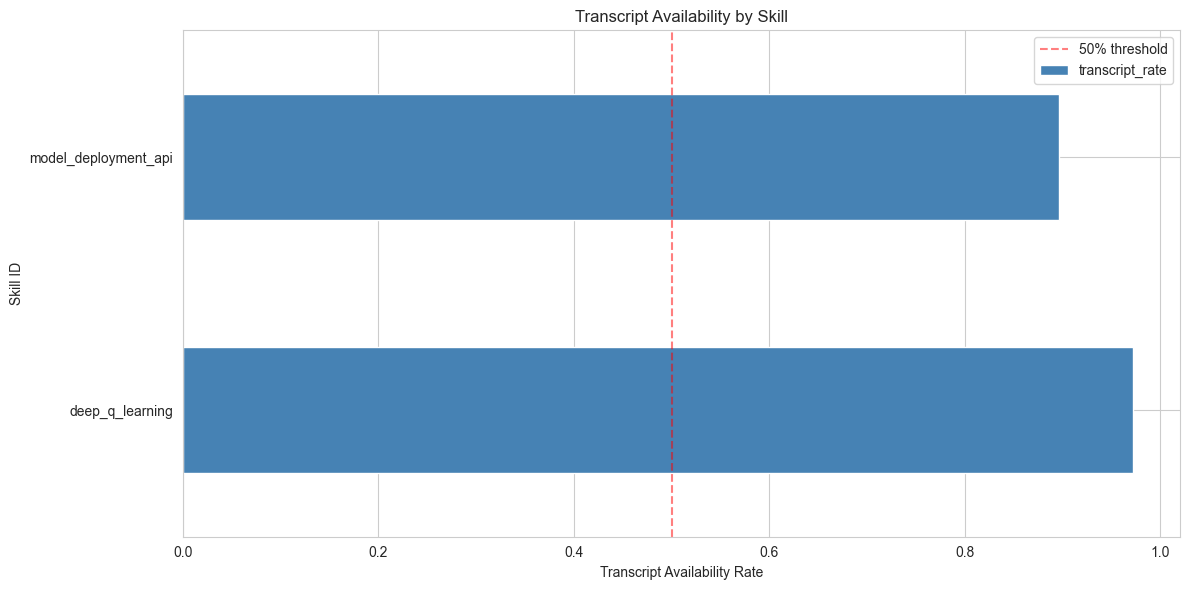

In [ ]:
# Visualize transcript availability
fig, ax = plt.subplots(figsize=(12, 6))
transcript_by_skill['transcript_rate'].plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Transcript Availability Rate')
ax.set_ylabel('Skill ID')
ax.set_title('Transcript Availability by Skill')
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend()
plt.tight_layout()
plt.show()

### 1.4 Filter Out Videos Without Transcripts

Since videos without transcripts are useless for our similarity-based ranking (which relies on transcript embeddings), we'll remove them from our dataset. All subsequent analysis will focus only on videos with available transcripts.

In [ ]:
# Filter to only keep videos with transcripts
print(f"Before filtering: {len(videos_filtered)} videos, {len(transcripts_filtered)} transcript records")

# Store original counts for comparison
original_video_count = len(videos_filtered)
original_transcript_count = len(transcripts_filtered)

# Keep only videos that have transcripts
videos_with_transcripts = transcripts_filtered[transcripts_filtered['has_transcript'] == True]['video_id'].unique()
videos_filtered = videos_filtered[videos_filtered['video_id'].isin(videos_with_transcripts)].copy()
transcripts_filtered = transcripts_filtered[transcripts_filtered['has_transcript'] == True].copy()

print(f"After filtering: {len(videos_filtered)} videos, {len(transcripts_filtered)} transcript records")
print(f"Removed {original_video_count - len(videos_filtered)} videos without transcripts")

print("\n Dataset now contains only videos with available transcripts")

#### Video Duration Analysis

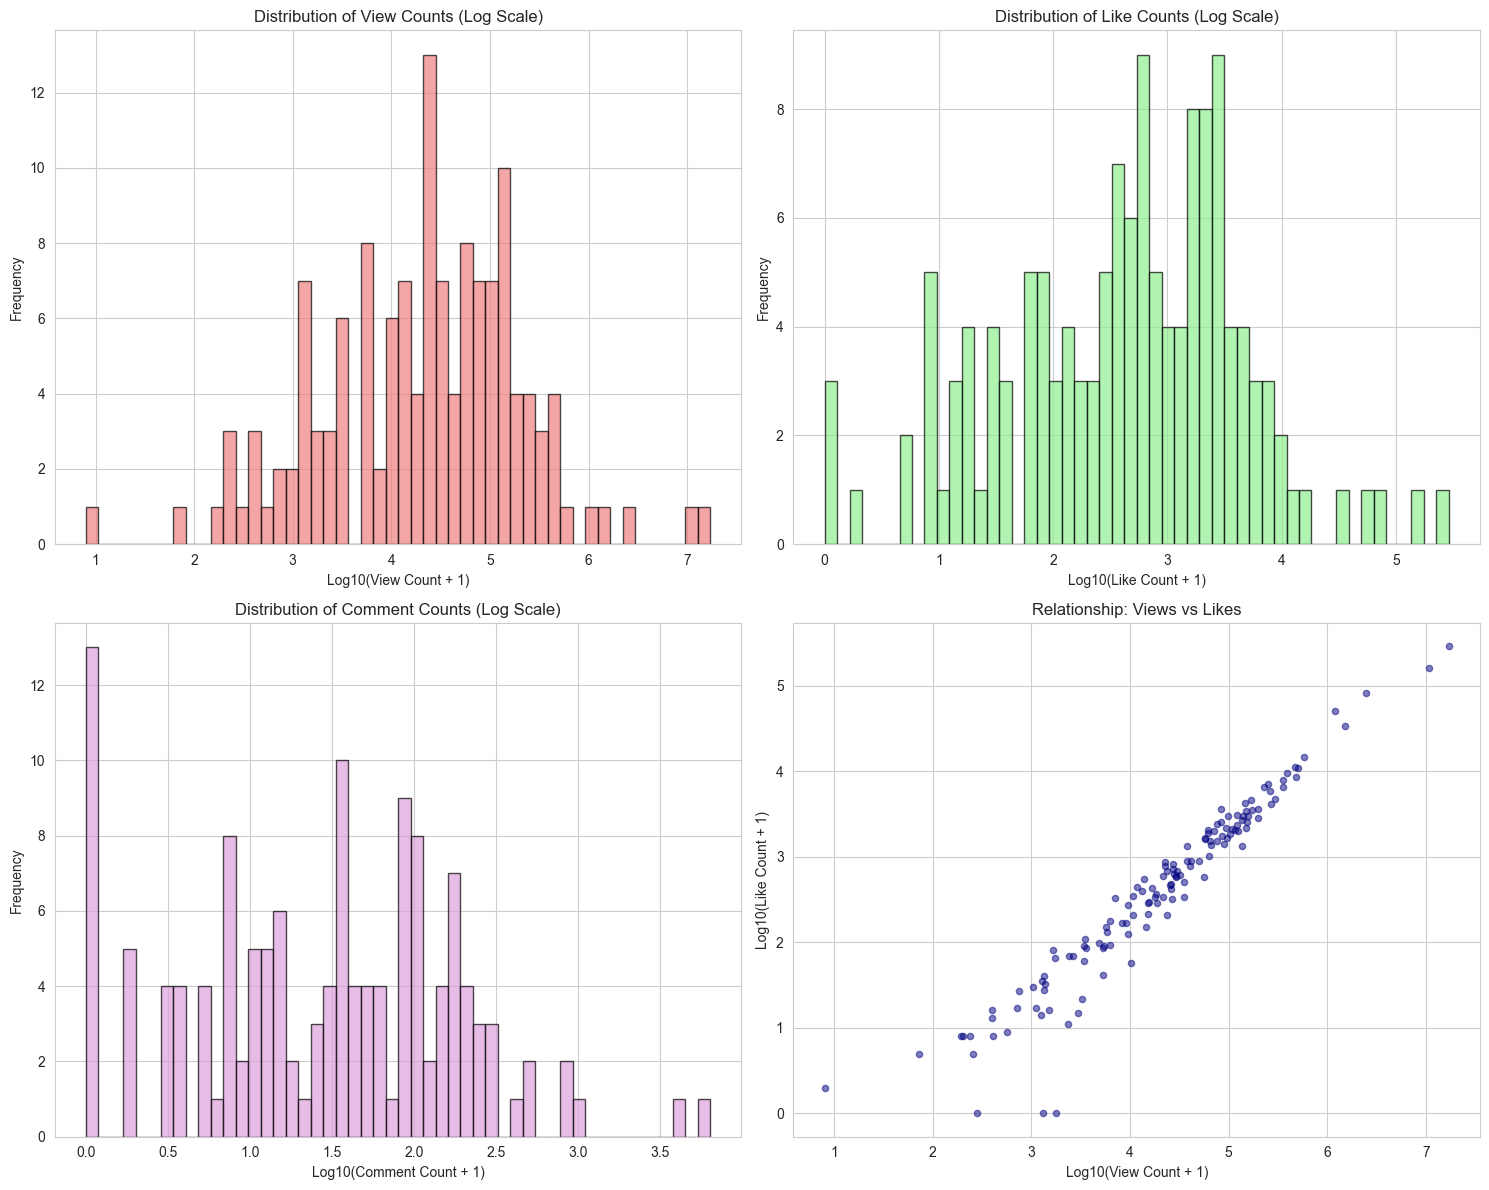


Engagement Metrics Statistics:
Views - Mean: 308463, Median: 25870
Likes - Mean: 5981, Median: 564
Comments - Mean: 164, Median: 34


In [ ]:
# Analyze engagement metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# View count distribution (log scale)
axes[0, 0].hist(np.log10(videos_filtered['view_count'] + 1), bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 0].set_xlabel('Log10(View Count + 1)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of View Counts (Log Scale)')

# Like count distribution (log scale)
axes[0, 1].hist(np.log10(videos_filtered['like_count'] + 1), bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Log10(Like Count + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Like Counts (Log Scale)')

# Comment count distribution (log scale)
axes[1, 0].hist(np.log10(videos_filtered['comment_count'] + 1), bins=50, edgecolor='black', alpha=0.7, color='plum')
axes[1, 0].set_xlabel('Log10(Comment Count + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Comment Counts (Log Scale)')

# Scatter: Views vs Likes
axes[1, 1].scatter(np.log10(videos_filtered['view_count'] + 1),
                   np.log10(videos_filtered['like_count'] + 1),
                   alpha=0.5, s=20, color='navy')
axes[1, 1].set_xlabel('Log10(View Count + 1)')
axes[1, 1].set_ylabel('Log10(Like Count + 1)')
axes[1, 1].set_title('Relationship: Views vs Likes')

plt.tight_layout()
plt.show()

print("\nEngagement Metrics Statistics:")
print(f"Views - Mean: {videos_filtered['view_count'].mean():.0f}, Median: {videos_filtered['view_count'].median():.0f}")
print(f"Likes - Mean: {videos_filtered['like_count'].mean():.0f}, Median: {videos_filtered['like_count'].median():.0f}")
print(f"Comments - Mean: {videos_filtered['comment_count'].mean():.0f}, Median: {videos_filtered['comment_count'].median():.0f}")

#### Engagement Metrics Analysis

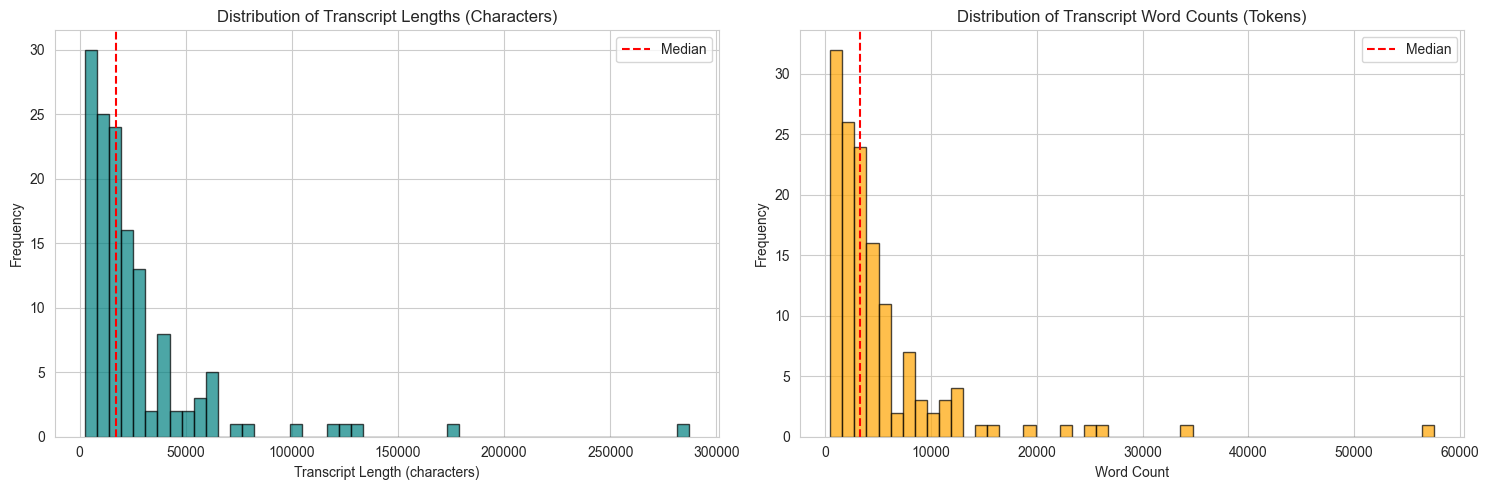


Transcript Length Statistics:
Characters - Mean: 26666, Median: 16982
Words - Mean: 5161, Median: 3237
Min words: 462, Max words: 57569

Note: Word count is used for chunking (we target 500-700 tokens per chunk)


In [ ]:
# Analyze transcript lengths
# transcript_length = total characters (including spaces, punctuation)
# word_count = number of words/tokens (what we'll use for chunking)
transcripts_filtered['transcript_length'] = transcripts_filtered['transcript_text'].str.len()
transcripts_filtered['word_count'] = transcripts_filtered['transcript_text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character count distribution
axes[0].hist(transcripts_filtered['transcript_length'], bins=50, edgecolor='black', alpha=0.7, color='teal')
axes[0].set_xlabel('Transcript Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Transcript Lengths (Characters)')
axes[0].axvline(transcripts_filtered['transcript_length'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

# Word count distribution
axes[1].hist(transcripts_filtered['word_count'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Transcript Word Counts (Tokens)')
axes[1].axvline(transcripts_filtered['word_count'].median(), color='red', linestyle='--', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nTranscript Length Statistics:")
print(f"Characters - Mean: {transcripts_filtered['transcript_length'].mean():.0f}, Median: {transcripts_filtered['transcript_length'].median():.0f}")
print(f"Words - Mean: {transcripts_filtered['word_count'].mean():.0f}, Median: {transcripts_filtered['word_count'].median():.0f}")
print(f"Min words: {transcripts_filtered['word_count'].min()}, Max words: {transcripts_filtered['word_count'].max()}")
print(f"\nNote: Word count is used for chunking (we target 500-700 tokens per chunk)")

#### Transcript Length Analysis

### 2.2 Data Preprocessing - Transcript Cleaning

Now we'll implement the first two steps of Module 2:
1. Clean and normalize transcripts
2. Segment transcripts into chunks (500-700 tokens)

#### Step 1: Clean and Normalize Transcripts


In [ ]:
import re
import unicodedata
import pandas as pd

def clean_transcript(text):
    """
    Clean and normalize transcript text.
    """
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Normalize unicode characters
    text = unicodedata.normalize('NFKD', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove timestamps (formats like [00:00], 00:00, (00:00))
    text = re.sub(r'\[?\d{1,2}:\d{2}(?::\d{2})?\]?', '', text)
    text = re.sub(r'\(\d{1,2}:\d{2}(?::\d{2})?\)', '', text)

    # Remove special characters and emojis (keep only letters, numbers, spaces, and basic punctuation)
    text = re.sub(r'[^\w\s.,!?;:\'-]', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)

    # Lowercase
    text = text.lower().strip()

    return text

print("Cleaning transcripts...")
transcripts_filtered["transcript_length"] = transcripts_filtered["transcript_text"].str.len()
transcripts_filtered["cleaned_text"] = transcripts_filtered["transcript_text"].apply(clean_transcript)

print("\n=== Before/After Cleaning Examples ===")
for i in range(min(3, len(transcripts_filtered))):
    print(f"\n--- Example {i+1} ---")
    print(f"BEFORE: {transcripts_filtered.iloc[i]['transcript_text'][:200]}...")
    print(f"AFTER:  {transcripts_filtered.iloc[i]['cleaned_text'][:200]}...")

transcripts_filtered["cleaned_length"] = transcripts_filtered["cleaned_text"].str.len()
print("\n=== Cleaning Statistics ===")
avg_reduction = (
    transcripts_filtered["transcript_length"].mean()
    - transcripts_filtered["cleaned_length"].mean()
) / transcripts_filtered["transcript_length"].mean() * 100
print(f"Average length reduction: {avg_reduction:.2f}%")
print(f"Empty transcripts after cleaning: {(transcripts_filtered['cleaned_text'].str.len() == 0).sum()}")


Cleaning transcripts...

=== Before/After Cleaning Examples ===

--- Example 1 ---
BEFORE: hey everyone welcome to my deep Q learning tutorial here's what to expect from this video since deep Q learning is a little bit complicated to explain I'm going to use the fren Lake reinforcement lear...
AFTER:  hey everyone welcome to my deep q learning tutorial here's what to expect from this video since deep q learning is a little bit complicated to explain i'm going to use the fren lake reinforcement lear...

--- Example 2 ---
BEFORE: before reinforcement learning after reinforcement learning what's happening guys my name is nicholas and in this video we're going to be going through a bit of a crash course on reinforcement learning...
AFTER:  before reinforcement learning after reinforcement learning what's happening guys my name is nicholas and in this video we're going to be going through a bit of a crash course on reinforcement learning...

--- Example 3 ---
BEFORE: greetings fellow Learne

#### Step 2: Segment Transcripts into Chunks

We'll segment transcripts into 500-700 token chunks for embedding generation. This ensures:
- Chunks are large enough to contain meaningful context
- Chunks fit within SBERT's token limits (typically 512 tokens)
- Overlap between chunks to preserve continuity

In [ ]:
from typing import List, Dict
import re


# Simple tokenizer (approximates SBERT tokenization)
MODEL_MAX_TOKENS = 384  # all-mpnet-base-v2 max length
DEFAULT_MAX_TOKENS = 360  # safe buffer
DEFAULT_MIN_TOKENS = 120  # avoid tiny chunks


def count_tokens(text: str) -> int:
    """Approximate token count (1.3x word count is typical for SBERT)"""
    words = text.split()
    return int(len(words) * 1.3)  # Approximate subword tokenization



def sentence_split(text: str) -> List[str]:
    """
    Simple sentence splitter using punctuation.
    """
    # Split on ., !, ? followed by whitespace
    sentences = re.split(r'(?<=[.!?])\s+', text)
    # Clean up empties
    return [s.strip() for s in sentences if s.strip()]


def split_long_sentence(sentence: str, max_tokens: int) -> List[str]:
    """
    Split a long sentence into smaller chunks based on words.
    Tries to split at natural boundaries (commas, conjunctions) when possible.
    """
    words = sentence.split()
    chunks = []

    # Approximate words per chunk (tokens are ~1.3x words)
    words_per_chunk = int(max_tokens / 1.3)

    i = 0
    while i < len(words):
        chunk_words = words[i:i + words_per_chunk]
        chunk_text = ' '.join(chunk_words)
        chunks.append(chunk_text)
        i += words_per_chunk

    return chunks


def segment_transcript_sbert(
    text: str,
    min_tokens: int = DEFAULT_MIN_TOKENS,
    max_tokens: int = DEFAULT_MAX_TOKENS,
    sentence_overlap: int = 1,
) -> List[Dict]:
    """
    Segment transcript into SBERT-friendly chunks.

    - Chunks are based on sentences.
    - Each chunk stays under `max_tokens`.
    - Long sentences are split into smaller chunks.
    - Overlap: the next chunk starts `sentence_overlap` sentences before
      the end of the previous chunk, to maintain context.
    """
    if not text or not text.strip():
        return []

    sentences = sentence_split(text)
    if not sentences:
        return []

    # Make sure overlap is not negative
    sentence_overlap = max(0, int(sentence_overlap))

    chunks: List[Dict] = []
    chunk_id = 0
    i = 0  # sentence index

    while i < len(sentences):
        current_sentences: List[str] = []
        current_tokens = 0
        start_idx = i

        while i < len(sentences):
            sent = sentences[i]
            sent_tokens = count_tokens(sent)

            # If a single sentence is too long, split it into sub-chunks
            if sent_tokens > max_tokens:
                # save any accumulated sentences
                if current_sentences:
                    chunk_text = " ".join(current_sentences)
                    actual_tokens = count_tokens(chunk_text)
                    if actual_tokens >= min_tokens or not chunks:
                        chunks.append({
                            "chunk_id": chunk_id,
                            "text": chunk_text,
                            "token_count": actual_tokens,
                            "start_sentence_idx": start_idx,
                            "end_sentence_idx": i - 1,
                        })
                        chunk_id += 1
                    current_sentences = []
                    current_tokens = 0

                # Split the long sentence into smaller chunks
                sub_chunks = split_long_sentence(sent, max_tokens)
                for sub_chunk in sub_chunks:
                    sub_tokens = count_tokens(sub_chunk)
                    chunks.append({
                        "chunk_id": chunk_id,
                        "text": sub_chunk,
                        "token_count": sub_tokens,
                        "start_sentence_idx": i,
                        "end_sentence_idx": i,
                    })
                    chunk_id += 1

                i += 1
                start_idx = i
                continue

            # Check if adding this sentence would exceed max_tokens
            if current_tokens + sent_tokens > max_tokens and current_sentences:
                # Stop and finalize this chunk
                break

            # Otherwise, add sentence to current chunk
            current_sentences.append(sent)
            current_tokens += sent_tokens
            i += 1

        # Finalize the current chunk (if any sentences)
        if current_sentences:
            chunk_text = " ".join(current_sentences)
            actual_tokens = count_tokens(chunk_text)
            if actual_tokens >= min_tokens or not chunks:
                chunks.append({
                    "chunk_id": chunk_id,
                    "text": chunk_text,
                    "token_count": actual_tokens,
                    "start_sentence_idx": start_idx,
                    "end_sentence_idx": i - 1,
                })
                chunk_id += 1

        # If we've reached the end, break
        if i >= len(sentences):
            break

        # Move the start index back by `sentence_overlap` sentences for overlap
        # but make sure we always move forward overall to avoid infinite loops
        next_start = max(i - sentence_overlap, 0)
        if next_start <= start_idx:
            next_start = i  # no overlap if it would cause no progress
        i = next_start

    return chunks

print(" Using approximate tokenization (PyTorch/SBERT not loaded)")
print(f"Max tokens per chunk: {DEFAULT_MAX_TOKENS}")


#### Apply Segmentation to All Transcripts

In [ ]:
# Segment all transcripts using SBERT tokenization
print("Segmenting all transcripts...")
all_chunks = []

for idx, row in transcripts_filtered.iterrows():
    video_id = row['video_id']
    cleaned_text = row['cleaned_text']

    # Skip empty transcripts
    if not cleaned_text or len(cleaned_text.strip()) == 0:
        continue

    # Segment transcript using SBERT-aware chunking
    chunks = segment_transcript_sbert(cleaned_text)

    # Add video_id to each chunk
    for chunk in chunks:
        chunk['video_id'] = video_id
        all_chunks.append(chunk)

# Create DataFrame of chunks
chunks_df = pd.DataFrame(all_chunks)

print(f"\n=== Segmentation Results ===")
print(f"Total videos processed: {len(transcripts_filtered)}")
print(f"Total chunks created: {len(chunks_df)}")
print(f"Average chunks per video: {len(chunks_df) / len(transcripts_filtered):.2f}")
print(f"\nChunk token statistics:")
print(chunks_df['token_count'].describe())

# Show distribution of chunks per video
chunks_per_video = chunks_df.groupby('video_id').size()
print(f"\nChunks per video distribution:")
print(chunks_per_video.describe())

Segmenting all transcripts...

=== Segmentation Results ===
Total videos processed: 138
Total chunks created: 2839
Average chunks per video: 20.57

Chunk token statistics:
count    2839.000000
mean      329.840085
std        71.439368
min         1.000000
25%       353.000000
50%       358.000000
75%       358.000000
max       378.000000
Name: token_count, dtype: float64

Chunks per video distribution:
count    138.000000
mean      20.572464
std       27.503918
min        2.000000
25%        7.000000
50%       13.000000
75%       22.000000
max      239.000000
dtype: float64


#### Visualize Chunk Distribution

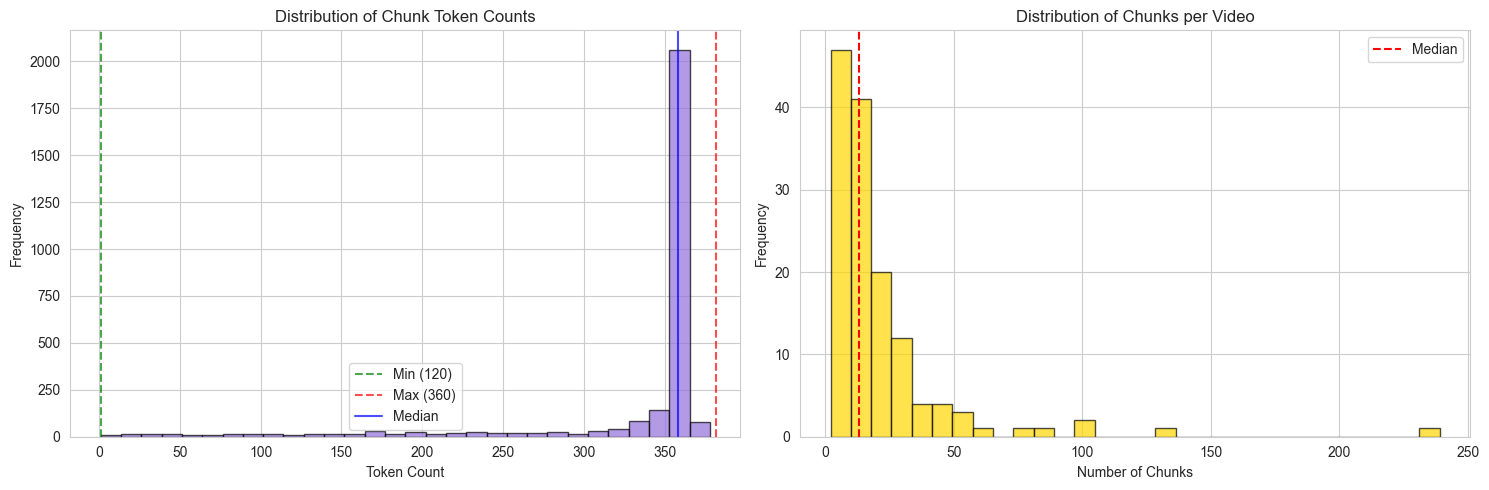

In [ ]:
# Visualize chunk statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Token count distribution
axes[0].hist(chunks_df['token_count'], bins=30, edgecolor='black', alpha=0.7, color='mediumpurple')
axes[0].set_xlabel('Token Count')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Chunk Token Counts')
axes[0].axvline(1, color='green', linestyle='--', label='Min (120)', alpha=0.7)
axes[0].axvline(382, color='red', linestyle='--', label='Max (360)', alpha=0.7)
axes[0].axvline(chunks_df['token_count'].median(), color='blue', linestyle='-', label='Median', alpha=0.7)
axes[0].legend()

# Chunks per video distribution
axes[1].hist(chunks_per_video, bins=30, edgecolor='black', alpha=0.7, color='gold')
axes[1].set_xlabel('Number of Chunks')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Chunks per Video')
axes[1].axvline(chunks_per_video.median(), color='red', linestyle='--', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Save Processed Data

Save the cleaned transcripts and chunks for next steps (embedding generation)

In [ ]:
from pathlib import Path
import json

# Save cleaned transcripts
output_dir = DATA_DIR
output_dir.mkdir(parents=True, exist_ok=True)

# Save cleaned transcripts (overwrite with cleaned version)
transcripts_cleaned = transcripts_filtered[["video_id", "cleaned_text"]].copy()
transcripts_cleaned.to_csv(output_dir / "transcripts_cleaned.csv", index=False)

# Save chunks
chunks_df = pd.DataFrame(all_chunks)
chunks_df.to_csv(output_dir / "transcript_chunks.csv", index=False)

# Save preprocessing summary
summary = {
    "total_videos": len(transcripts_filtered),
    "total_chunks": len(chunks_df),
    "avg_chunks_per_video": len(chunks_df) / len(transcripts_filtered),
    "avg_words_per_chunk": chunks_df["word_count"].mean(),
    "skills_distribution": chunks_df["skill_id"].value_counts().to_dict()
}

with open(output_dir / "preprocessing_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print(f"Saved cleaned transcripts to {output_dir / 'transcripts_cleaned.csv'}")
print(f"Saved {len(chunks_df)} chunks to {output_dir / 'transcript_chunks.csv'}")
print(f"Saved summary statistics to {output_dir / 'preprocessing_summary.json'}")

print("\n=== Module 2 - Steps 1 & 2 Complete ===")
print(" Transcripts cleaned and normalized")
print(" Transcripts segmented into SBERT-friendly chunks (~≤ 360 tokens)")

print("\nNext steps:")
print("- Generate SBERT embeddings for each chunk")
print("- Build FAISS index for efficient similarity search")

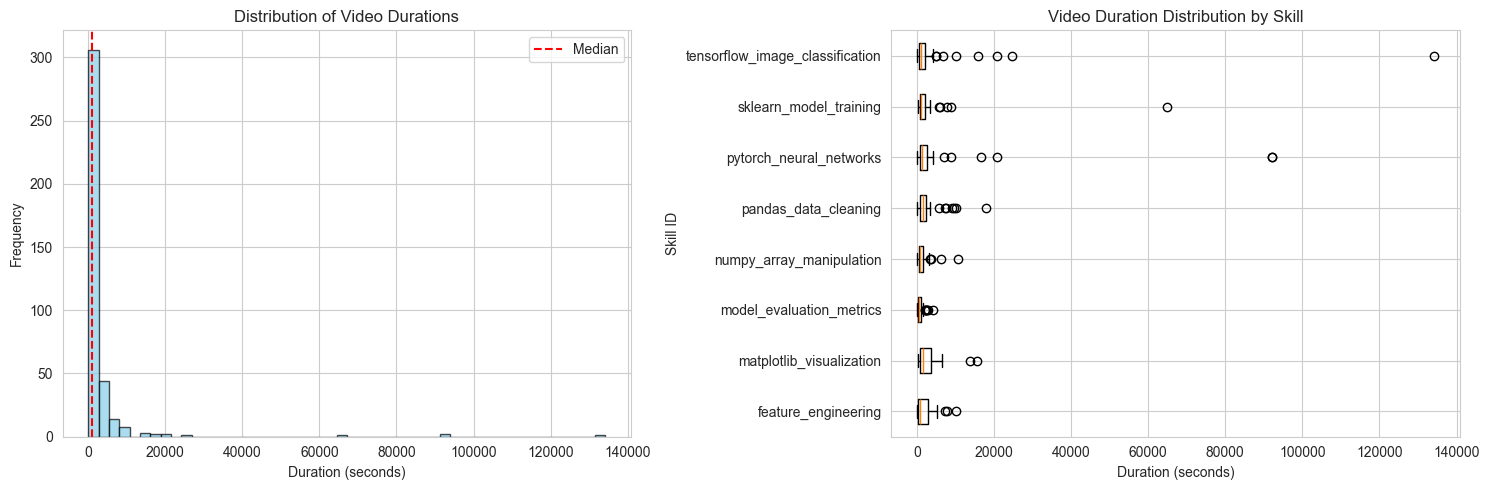


Duration Statistics:
Min: 91 seconds
Max: 134201 seconds
Mean: 3028.86 seconds
Median: 1070.00 seconds


In [ ]:
# Analyze video duration statistics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of durations
axes[0].hist(videos_filtered['duration_seconds'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Duration (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Video Durations')
axes[0].axvline(videos_filtered['duration_seconds'].median(), color='red', linestyle='--', label='Median')
axes[0].legend()

# Box plot by skill
video_skill_merged = videos_filtered.merge(video_skill_candidates, on='video_id', how='left')
skill_durations = video_skill_merged.groupby('skill_id')['duration_seconds'].apply(list)
axes[1].boxplot(skill_durations.values, labels=skill_durations.index, vert=False)
axes[1].set_xlabel('Duration (seconds)')
axes[1].set_ylabel('Skill ID')
axes[1].set_title('Video Duration Distribution by Skill')

plt.tight_layout()
plt.show()

print(f"\nDuration Statistics:")
print(f"Min: {videos_filtered['duration_seconds'].min()} seconds")
print(f"Max: {videos_filtered['duration_seconds'].max()} seconds")
print(f"Mean: {videos_filtered['duration_seconds'].mean():.2f} seconds")
print(f"Median: {videos_filtered['duration_seconds'].median():.2f} seconds")